## Objective

The goal of this project is to predict vehicle CO₂ emissions (g/km) using technical characteristics (engine, cylinders, transmission, fuel type, vehicle class, model year, etc.).  
This is a supervised regression problem, since the target is continuous.

Target variable: `co2emission_g_km`  
Main idea: build a first baseline, understand its limitations, then improve the dataset and the models.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MY1995-2023-Fuel-Consumption-Ratings.csv to MY1995-2023-Fuel-Consumption-Ratings (1).csv


## EDA


Before training models, we look at:
- the distribution of the target
- differences in CO2 by fuel type and vehicle class
- correlations between numerical variables

This helps detect redundancy between variables and possible data leakage.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

filename = next(iter(uploaded))
df = pd.read_csv(filename)
df.head()

,ModelYear,Make,Model,VehicleClass,EngineSize_L,Cylinders,Transmission,FuelType,FuelConsCity_L100km,FuelConsHwy_L100km,Comb_L100km,Comb_mpg,CO2Emission_g_km,CO2Rating,SmogRating
0,1995,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.6,8.3,10.1,28,232,NaN,NaN
1,1995,ACURA,INTEGRA,SUBCOMPACT,1.8,4,M5,X,11.0,8.3,9.8,29,225,NaN,NaN
2,1995,ACURA,INTEGRA GS-R,SUBCOMPACT,1.8,4,M5,Z,10.8,8.3,9.7,29,223,NaN,NaN
3,1995,ACURA,LEGEND,COMPACT,3.2,6,A4,Z,14.2,10.5,12.5,23,288,NaN,NaN
4,1995,ACURA,LEGEND COUPE,COMPACT,3.2,6,A4,Z,14.6,11.0,13.0,22,299,NaN,NaN


In [ ]:
df.info() #dataset overview (types, missing values, memory)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27001 entries, 0 to 27000
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ModelYear            27001 non-null  int64  
 1   Make                 27001 non-null  object 
 2   Model                27001 non-null  object 
 3   VehicleClass         27001 non-null  object 
 4   EngineSize_L         27001 non-null  float64
 5   Cylinders            27001 non-null  int64  
 6   Transmission         27001 non-null  object 
 7   FuelType             27001 non-null  object 
 8   FuelConsCity_L100km  27001 non-null  float64
 9   FuelConsHwy_L100km   27001 non-null  float64
 10  Comb_L100km          27001 non-null  float64
 11  Comb_mpg             27001 non-null  int64  
 12  CO2Emission_g_km     27001 non-null  int64  
 13  CO2Rating            8010 non-null   float64
 14  SmogRating           6900 non-null   float64
dtypes: float64(6), int64(4), object(5)
m

In [ ]:
df.describe() #summary statistics for numerical features

,ModelYear,EngineSize_L,Cylinders,FuelConsCity_L100km,FuelConsHwy_L100km,Comb_L100km,Comb_mpg,CO2Emission_g_km,CO2Rating,SmogRating
count,27001.000000,27001.000000,27001.000000,27001.000000,27001.000000,27001.000000,27001.000000,27001.000000,8010.000000,6900.000000
mean,2009.999630,3.347661,5.837154,13.841687,10.010014,12.117559,24.933669,275.524129,4.644444,4.742319
std,7.938602,1.342770,1.803504,3.743247,2.589578,3.186844,6.731678,65.881966,1.605155,1.788978
min,1995.000000,0.800000,2.000000,4.000000,3.900000,4.000000,10.000000,94.000000,1.000000,1.000000
25%,2004.000000,2.300000,4.000000,11.300000,8.200000,9.900000,20.000000,230.000000,4.000000,3.000000
50%,2010.000000,3.000000,6.000000,13.400000,9.500000,11.600000,24.000000,268.000000,5.000000,5.000000
75%,2017.000000,4.200000,8.000000,15.900000,11.400000,13.900000,29.000000,315.000000,6.000000,6.000000
max,2023.000000,8.400000,16.000000,33.300000,22.100000,27.500000,71.000000,633.000000,10.000000,8.000000


In [ ]:
print("Shape:", df.shape) #Total shape of the dataset

Shape: (27001, 15)


In [ ]:
print(df.columns.tolist()) #display column names (useful for feature selection)

['ModelYear', 'Make', 'Model', 'VehicleClass', 'EngineSize_L', 'Cylinders', 'Transmission', 'FuelType', 'FuelConsCity_L100km', 'FuelConsHwy_L100km', 'Comb_L100km', 'Comb_mpg', 'CO2Emission_g_km', 'CO2Rating', 'SmogRating']


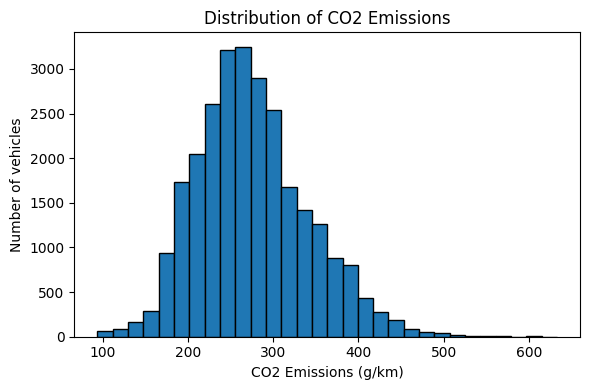

In [ ]:
# Target distribution (CO2 emissions)
target_col = "CO2Emission_g_km" if "CO2Emission_g_km" in df.columns else "co2emission_g_km"

plt.figure(figsize=(6, 4))
plt.hist(df[target_col], bins=30, edgecolor="black")
plt.xlabel("CO2 Emissions (g/km)")
plt.ylabel("Number of vehicles")
plt.title("Distribution of CO2 Emissions")
plt.tight_layout()
plt.show()
#graphe to visulise the number of vehicules with their CO2 emissions

<Figure size 700x500 with 0 Axes>

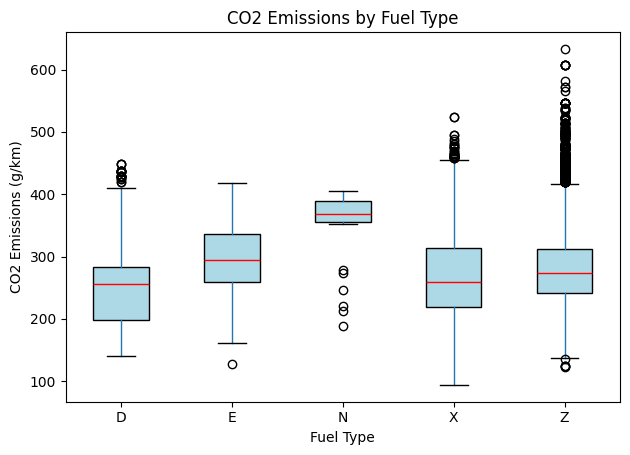

In [ ]:
# Boxplot: CO2 emissions by fuel type
target_col = "CO2Emission_g_km" if "CO2Emission_g_km" in df.columns else "co2emission_g_km"
fuel_col = "FuelType" if "FuelType" in df.columns else "fueltype"

plt.figure(figsize=(7, 5))
df.boxplot(
    column=target_col,
    by=fuel_col,
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="red")
)
plt.title("CO2 Emissions by Fuel Type")
plt.suptitle("")
plt.xlabel("Fuel Type")
plt.ylabel("CO2 Emissions (g/km)")
plt.tight_layout()
plt.show()


In [ ]:
# Initial observation:
# Some columns are not immediately interpretable (abbreviations, mixed formats).
# We therefore perform a cleaning step: standardize column names, check missing values/duplicates,
# and confirm data types before modeling.


In [ ]:
# Data preprocessing
# Step 1: standardize column names (lowercase + snake_case)

df_prep = df.copy()

df_prep.columns = (
    df_prep.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^a-z0-9]+", "_", regex=True)
    .str.strip("_")
)

# Quick check
df_prep.columns.tolist()


['modelyear',
 'make',
 'model',
 'vehicleclass',
 'enginesize_l',
 'cylinders',
 'transmission',
 'fueltype',
 'fuelconscity_l100km',
 'fuelconshwy_l100km',
 'comb_l100km',
 'comb_mpg',
 'co2emission_g_km',
 'co2rating',
 'smograting']

In [ ]:
# Step 2: check missing values
missing_counts = df_prep.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df_prep) * 100).round(2)

pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct}).head(20)


,missing_count,missing_pct
smograting,20101,74.45
co2rating,18991,70.33
modelyear,0,0.00
vehicleclass,0,0.00
enginesize_l,0,0.00
make,0,0.00
model,0,0.00
transmission,0,0.00
cylinders,0,0.00
fueltype,0,0.00


In [ ]:
# We observe a high proportion of missing values in 'co2rating' and 'smograting'.
# We keep them for the initial baseline + EDA (to identify potential leakage),
# and we will decide later whether to drop or impute them depending on their impact.


In [ ]:
# Decode fuel type codes to make the dataset easier to interpret
fuel_map = {
    "X": "regular_gasoline",
    "Z": "premium_gasoline",
    "D": "diesel",
    "E": "ethanol_e85",
    "N": "natural_gas"
}

# Keep the original code column and create a readable version
df_prep["fuel_type_decoded"] = df_prep["fueltype"].map(fuel_map)

# If some codes are not in the map, keep the original code as fallback
df_prep["fuel_type_decoded"] = df_prep["fuel_type_decoded"].fillna(df_prep["fueltype"])

df_prep["fuel_type_decoded"].value_counts()

,count
fuel_type_decoded,
regular_gasoline,14847
premium_gasoline,10536
ethanol_e85,1091
diesel,488
natural_gas,39


In [ ]:
# Define target (y) and explanatory variables (X)
target_col = "co2emission_g_km"

feature_cols = [
    "enginesize_l",
    "cylinders",
    "transmission",
    "fueltype_decoded",
    "fuelconscity_l100km",
    "fuelconshwy_l100km",
    "comb_l100km",
    "comb_mpg",
    "vehicleclass",
    "modelyear"
]

#Keep only columns that exist
feature_cols = [c for c in feature_cols if c in df_prep.columns]

X = df_prep[feature_cols]
y = df_prep[target_col]

X.head()


,enginesize_l,cylinders,transmission,fuelconscity_l100km,fuelconshwy_l100km,comb_l100km,comb_mpg,vehicleclass,modelyear
0,1.8,4,A4,11.6,8.3,10.1,28,SUBCOMPACT,1995
1,1.8,4,M5,11.0,8.3,9.8,29,SUBCOMPACT,1995
2,1.8,4,M5,10.8,8.3,9.7,29,SUBCOMPACT,1995
3,3.2,6,A4,14.2,10.5,12.5,23,COMPACT,1995
4,3.2,6,A4,14.6,11.0,13.0,22,COMPACT,1995


## 3. Problem formalization

**Problem type and objective**

This is a supervised regression problem: we aim to predict a continuous value, CO₂ emissions in g/km. The objective is to identify the main technical characteristics that impact CO₂ emissions.

**Model variables**

The target variable (y) is the CO₂ emission level in g/km. The input features (X) include numerical variables such as engine size, number of cylinders, and fuel consumption in city, highway, and combined driving. We also have categorical variables: manufacturer, specific model, transmission type, fuel type, and vehicle class. It could also be relevant to enrich the dataset by adding the vehicle model year or weight (per vehicle or per category), if available.

**Evaluation metrics**

We will use several complementary metrics to evaluate our models. MAE provides the average error in g/km and is easy to interpret. RMSE penalizes large errors more strongly, which is useful to detect major inconsistencies. R² measures the proportion of variance explained by the model, but should not be used alone. We will also include visual diagnostics such as residual distributions, a scatter plot of predicted vs. actual values, and error analysis across groups (e.g., by fuel type).

**Constraints**

We will start with a simple linear regression as an interpretable baseline, then increase model complexity with methods such as Random Forest or Gradient Boosting to improve accuracy. The goal is to build a robust model validated through cross-validation rather than optimizing performance on a single train/test split. We also need to handle high-cardinality categorical columns (e.g., the exact vehicle model), which can lead to very large one-hot encoded feature spaces.

**Workflow**

The approach follows a standard machine learning pipeline: exploratory data analysis to understand distributions and correlations, data cleaning and missing-value handling, potential feature engineering, encoding categorical variables and scaling numerical features, and finally train/test splitting combined with cross-validation. We will first train a linear regression baseline, then compare it to more advanced models.


#### 4. Baseline model selection and implementation

We start by building a simple baseline model to predict vehicle CO₂ emissions from their technical characteristics.  
This baseline provides a first reference point and will be used to compare the performance of more advanced models later in the project.


In [60]:
# Define target and features for the baseline
target = "co2emission_g_km"


# Drop high-cardinality column to avoid huge one-hot encoding and memorization
if "model" in df.columns:
    df = df.drop(columns=["model"])

X = df_prep.drop(columns=[target])
y = df_prep[target]

# Numerical features (include fuel consumption -> expected very high R2)
num_cols = [
    "modelyear" ,
    "enginesize_l",
    "cylinders",
    "fuelconscity_l100km",
    "fuelconshwy_l100km",
    "comb_l100km",
    "comb_mpg"
]

# Categorical features (avoid high-cardinality columns for the baseline)
cat_cols = [
    "make",
    "vehicleclass",
    "transmission",
    "fueltype_decoded"
]

# Keep only existing columns (robustness)
num_cols = [c for c in num_cols if c in X.columns]
cat_cols = [c for c in cat_cols if c in X.columns]


print(f"Numerical features: {num_cols}")
print(f"Categorical features: {cat_cols}")

Numerical features: ['modelyear', 'enginesize_l', 'cylinders', 'fuelconscity_l100km', 'fuelconshwy_l100km', 'comb_l100km', 'comb_mpg']
Categorical features: ['make', 'vehicleclass', 'transmission']


In [ ]:
# Preprocessing and baseline model (Linear Regression)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)  # keep sparse (memory efficient)
    ]
)

# Baseline model: Linear Regression
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [ ]:
# Train/test split
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
# This allows us to fit the model on training data and evaluate generalization on unseen data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (18900, 15)
Test set shape: (8101, 15)


## Baseline: linear regression

We start with a simple baseline using linear regression with standardization for numerical features and one-hot encoding for categorical features.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the model on the training set
baseline_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = baseline_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)                 #average absolute error (g/km)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))        #penalizes large errors
r2 = r2_score(y_test, y_pred)                             # proportion of explained variance

print("=== Baseline model performance (Linear Regression) ===")
print(f"MAE  : {mae:.2f} g/km")
print(f"RMSE : {rmse:.2f} g/km")
print(f"R2   : {r2:.3f}")

# with fuel consumption variables are included, R2 can be unrealistically higt because fuel consumption is a strong proxy for CO2 emissions.


=== Baseline model performance (Linear Regression) ===
MAE  : 11.71 g/km
RMSE : 17.79 g/km
R2   : 0.928



The R2 score is extremely high. This suggests that some variables might act as direct proxies of the target.



In [58]:
#Cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(baseline_model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_cv = -scores.mean()
std_cv = scores.std()

print("=== Cross-validation (5 folds) ===")
print(f"Mean MAE: {mae_cv:.2f} g/km (+/- {std_cv:.2f})")

=== Cross-validation (5 folds) ===
Mean MAE: 13.88 g/km (+/- 1.03)


The cross-validation MAE is only slightly higher than the simple test result, indicating model stability and low sensitivity to the data split.

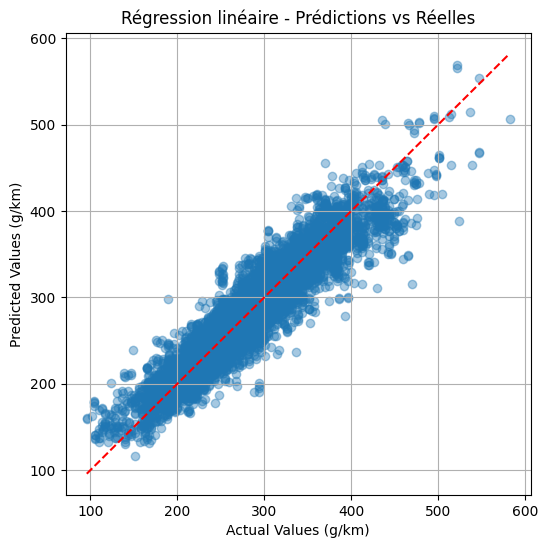

In [59]:
#Visualisation of the predictions
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values (g/km)")
plt.ylabel("Predicted Values (g/km)")
plt.title("Régression linéaire - Prédictions vs Réelles")
plt.grid(True)
plt.show()


## Explaining the unrealistic performance

To understand why the baseline performs so well, we use correlation analysis and permutation importance.


                feature  importance_mean  importance_std
11             comb_mpg         0.161658        0.002417
4          enginesize_l         0.121651        0.001694
10          comb_l100km         0.054391        0.001043
1                  make         0.053579        0.001051
3          vehicleclass         0.046247        0.000817
0             modelyear         0.037213        0.000994
9    fuelconshwy_l100km         0.029835        0.000684
6          transmission         0.007477        0.000346
5             cylinders         0.007315        0.000197
8   fuelconscity_l100km         0.000232        0.000051
2                 model         0.000000        0.000000
7              fueltype         0.000000        0.000000
12            co2rating         0.000000        0.000000
13           smograting         0.000000        0.000000
14    fuel_type_decoded         0.000000        0.000000


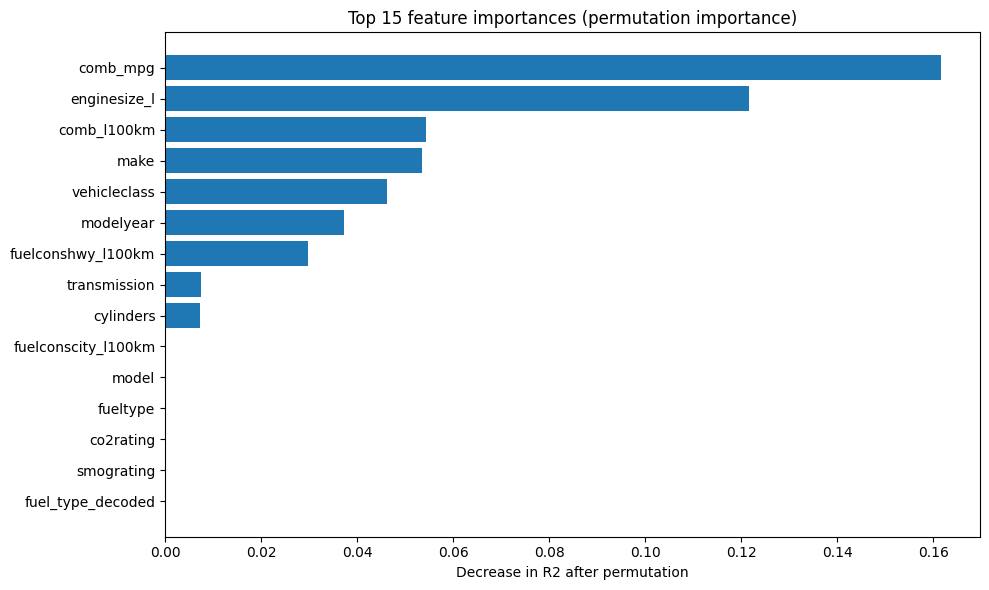

In [ ]:
#measure how much the test R2 drops when each feature is randomly shuffled this helps identify which input variables the baseline model relies on the most.

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    baseline_model,
    X_test, y_test,
    scoring="r2",
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

#build a ranked table of importances
imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print(imp.head(15))

#Plot the top 15 most important features
plt.figure(figsize=(10,6))
top = imp.head(15)
plt.barh(top["feature"][::-1], top["importance_mean"][::-1])
plt.xlabel("Decrease in R2 after permutation")
plt.title("Top 15 feature importances (permutation importance)")
plt.tight_layout()
plt.show()


Strongest absolute correlations with CO2:


,co2emission_g_km
co2emission_g_km,1.000000
co2rating,-0.944766
comb_l100km,0.933518
fuelconscity_l100km,0.930649
fuelconshwy_l100km,0.908668
comb_mpg,-0.905320
enginesize_l,0.824808
cylinders,0.791384
smograting,-0.457634
modelyear,-0.276442


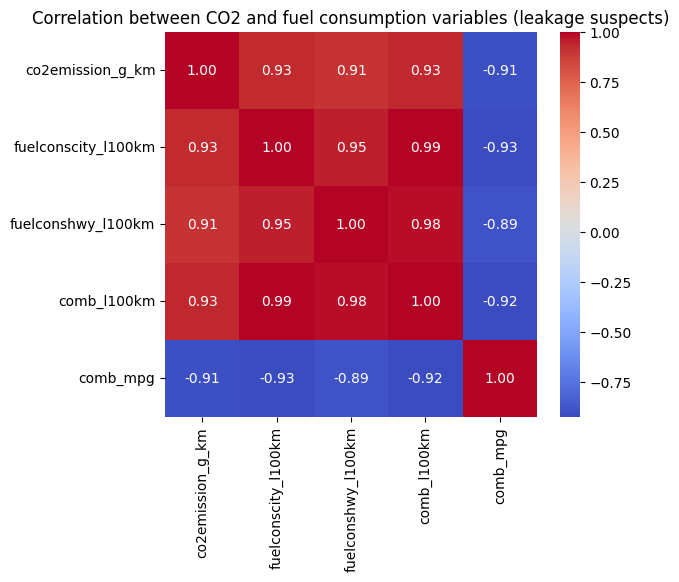

In [ ]:
# Correlation check to identify variables that are strongly linked to the target
# This helps detect potential leakage/proxy variables

num_df = df_prep.select_dtypes(include=["number"]).copy()

corr_target = num_df.corr(numeric_only=True)[target].sort_values(key=lambda s: s.abs(), ascending=False)
print("Strongest absolute correlations with CO2:")
display(corr_target.head(15))

import matplotlib.pyplot as plt
import seaborn as sns


suspects = [target, "fuelconscity_l100km", "fuelconshwy_l100km", "comb_l100km", "comb_mpg"]
suspects = [c for c in suspects if c in num_df.columns]

plt.figure(figsize=(6, 5))
sns.heatmap(num_df[suspects].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between CO2 and fuel consumption variables (leakage suspects)")
plt.show()


## Data leakage handling

To make the problem more realistic and aligned with the objective (predicting CO2 from technical characteristics), we remove proxy variables:
- fuel consumption variables (fuelcons*, comb_l100km, comb_mpg)
- rating variables derived from emissions/consumption when present (co2rating, smograting)

After removing them, the task becomes harder, but the evaluation becomes more meaningful.


In [ ]:
# Remove leakage/proxy features identified by permutation importance
leakage_cols = [
    "fuelconscity_l100km",
    "fuelconshwy_l100km",
    "comb_l100km",
    "comb_mpg",
    "co2rating",
    "smograting"
]

df_clean = df_prep.copy()

leakage_cols = [c for c in leakage_cols if c in df_clean.columns]
df_clean = df_clean.drop(columns=leakage_cols)

# Optional (recommended): drop high-cardinality 'model'
if "model" in df_clean.columns:
    df_clean = df_clean.drop(columns=["model"])

print("Dropped:", leakage_cols)
print("New shape:", df_clean.shape)


Dropped: ['fuelconscity_l100km', 'fuelconshwy_l100km', 'comb_l100km', 'comb_mpg', 'co2rating', 'smograting']
New shape: (27001, 9)


## Linear regression after removing proxy variables

We retrain the same linear regression pipeline after dropping the proxy variables.

In [ ]:
target = "co2emission_g_km"
X = df_clean.drop(columns=[target])
y = df_clean[target]

num_cols = [c for c in ["modelyear", "enginesize_l", "cylinders"] if c in X.columns]
cat_cols = [c for c in ["make", "vehicleclass", "transmission", "fueltype"] if c in X.columns]

# Preprocessor + model (same structure)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

baseline_clean = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

baseline_clean.fit(X_train, y_train)
y_pred = baseline_clean.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== Clean baseline (Linear Regression) ===")
print(f"MAE  : {mae:.2f} g/km")
print(f"RMSE : {rmse:.2f} g/km")
print(f"R2   : {r2:.3f}")


=== Clean baseline (Linear Regression) ===
MAE  : 17.60 g/km
RMSE : 23.36 g/km
R2   : 0.876


=== Linear Regression (clean) — Test set ===
MAE  : 17.60 g/km
RMSE : 23.36 g/km
R2   : 0.876


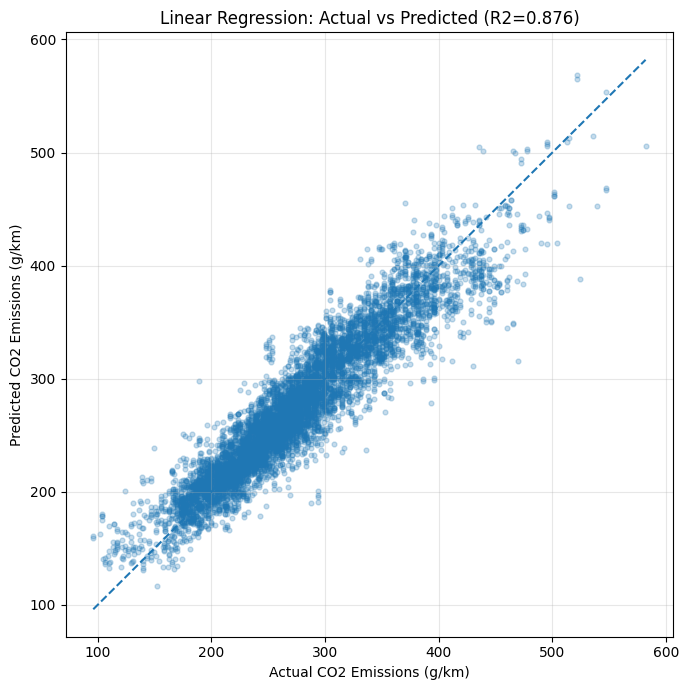

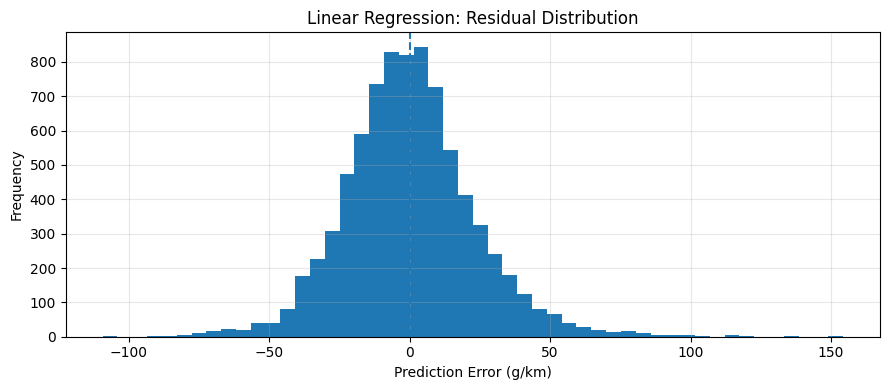

In [ ]:
# Cell — Train/test evaluation + visualizations (Linear Regression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

baseline_clean.fit(X_train, y_train)
y_pred_lr = baseline_clean.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("=== Linear Regression (clean) — Test set ===")
print(f"MAE  : {mae_lr:.2f} g/km")
print(f"RMSE : {rmse_lr:.2f} g/km")
print(f"R2   : {r2_lr:.3f}")

# Actual vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_lr, alpha=0.25, s=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.xlabel("Actual CO2 Emissions (g/km)")
plt.ylabel("Predicted CO2 Emissions (g/km)")
plt.title(f"Linear Regression: Actual vs Predicted (R2={r2_lr:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals
residuals_lr = y_test - y_pred_lr
plt.figure(figsize=(9, 4))
plt.hist(residuals_lr, bins=50)
plt.axvline(0, linestyle="--")
plt.xlabel("Prediction Error (g/km)")
plt.ylabel("Frequency")
plt.title("Linear Regression: Residual Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The R2 decreases and errors increase, which is normal. This second baseline is a more realistic reference for the next models.


### Advanced models on the cleaned dataset

We then train more powerful models on the cleaned dataset:
- random forest regressor
- SVR with dimensionality reduction, because one-hot encoding produces a high-dimensional sparse space
- XGBoost for a stronger boosting baseline

All models are evaluated on the same train/test split to compare them fairly.


In [ ]:
from sklearn.inspection import permutation_importance
# Here, let's begin with the analyse of the importance of the features, after the cleaning
perm = permutation_importance(
    baseline_clean,
    X_test, y_test,
    scoring="r2",
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print(imp.head(15))


             feature  importance_mean  importance_std
3       enginesize_l         0.442057        0.005503
2       vehicleclass         0.254255        0.002620
1               make         0.114933        0.001663
0          modelyear         0.086427        0.001883
4          cylinders         0.063675        0.001096
5       transmission         0.049674        0.001434
6           fueltype         0.028357        0.000586
7  fuel_type_decoded         0.000000        0.000000


In [ ]:
# Cell — Cross-validation (Linear Regression)
lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

r2_scores = cross_val_score(lr_model, X, y, cv=5, scoring="r2", n_jobs=-1)
mae_scores = -cross_val_score(lr_model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

print("=== Linear Regression — 5-fold CV ===")
print(f"Mean R2 : {r2_scores.mean():.3f} (+/- {r2_scores.std():.3f})")
print(f"Mean MAE: {mae_scores.mean():.2f} g/km (+/- {mae_scores.std():.2f})")


=== Linear Regression — 5-fold CV ===
Mean R2 : 0.813 (+/- 0.040)
Mean MAE: 20.25 g/km (+/- 2.14)


In [ ]:
# Cell — Random Forest

from sklearn.ensemble import RandomForestRegressor
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Random Forest (clean) — Test set ===")
print(f"MAE  : {mae_rf:.2f} g/km")
print(f"RMSE : {rmse_rf:.2f} g/km")
print(f"R2   : {r2_rf:.3f}")


=== Random Forest (clean) — Test set ===
MAE  : 9.63 g/km
RMSE : 14.34 g/km
R2   : 0.953


In [ ]:
# Cell — XGBoost
from xgboost import XGBRegressor
xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("=== XGBoost (clean) — Test set ===")
print(f"MAE  : {mae_xgb:.2f} g/km")
print(f"RMSE : {rmse_xgb:.2f} g/km")
print(f"R2   : {r2_xgb:.3f}")


=== XGBoost (clean) — Test set ===
MAE  : 11.46 g/km
RMSE : 15.34 g/km
R2   : 0.947


In [ ]:
# Cell — SVM
from sklearn.svm import LinearSVR
svm_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearSVR(random_state=42))
])

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

mae_svm = mean_absolute_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_svm = r2_score(y_test, y_pred_svm)

print("=== LinearSVR (clean) — Test set ===")
print(f"MAE  : {mae_svm:.2f} g/km")
print(f"RMSE : {rmse_svm:.2f} g/km")
print(f"R2   : {r2_svm:.3f}")


=== LinearSVR (clean) — Test set ===
MAE  : 17.86 g/km
RMSE : 24.43 g/km
R2   : 0.864


In [ ]:
rows = [
    {"Model": "Linear Regression", "R2": r2_lr, "MAE": mae_lr, "RMSE": rmse_lr},
    {"Model": "Random Forest", "R2": r2_rf, "MAE": mae_rf, "RMSE": rmse_rf},
    {"Model": "LinearSVR", "R2": r2_svm, "MAE": mae_svm, "RMSE": rmse_svm},
]

if "r2_xgb" in globals():
    rows.append({"Model": "XGBoost", "R2": r2_xgb, "MAE": mae_xgb, "RMSE": rmse_xgb})

results_df = pd.DataFrame(rows).sort_values("R2", ascending=False)
results_df


,Model,R2,MAE,RMSE
1,Random Forest,0.953254,9.632555,14.339234
3,XGBoost,0.946520,11.459260,15.337387
0,Linear Regression,0.875953,17.602311,23.358600
2,LinearSVR,0.864273,17.857091,24.433582


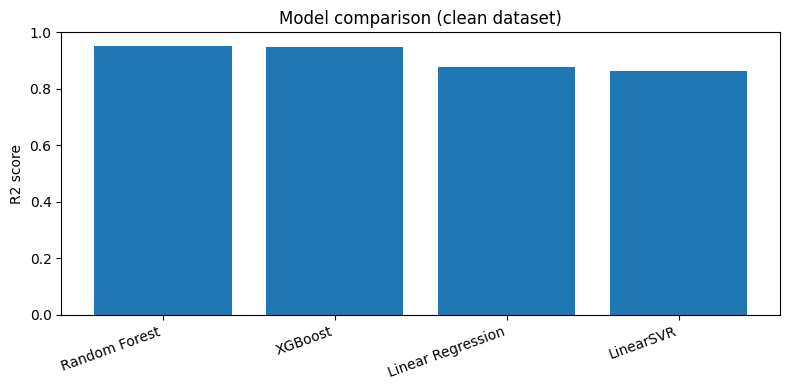

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["Model"], results_df["R2"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("R2 score")
plt.title("Model comparison (clean dataset)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


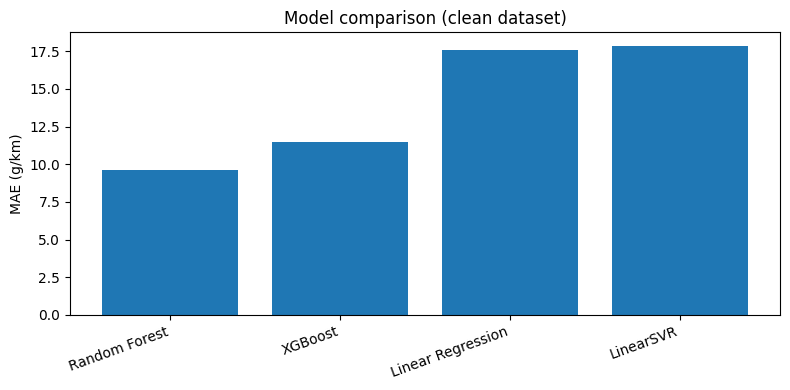

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["Model"], results_df["MAE"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("MAE (g/km)")
plt.title("Model comparison (clean dataset)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import KFold, cross_validate

# Ensure X and y are updated to reflect the cleaned df_prep and correct columns
target = "co2emission_g_km"
X = df_prep.drop(columns=[target])
y = df_prep[target]

# Cross-validation  same RF model + shuffled folds + single pass for R2 and MAE
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf_model_same = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=1
    ))
])

scores = cross_validate(
    rf_model_same,
    X, y,
    cv=cv,
    scoring={"r2": "r2", "mae": "neg_mean_absolute_error"},
    n_jobs=-1,
    return_train_score=False
)

rf_r2 = scores["test_r2"]
rf_mae = -scores["test_mae"]

print("=== Random Forest — 5-fold CV (shuffle, same model) ===")
print(f"Mean R2 : {rf_r2.mean():.3f} (+/- {rf_r2.std():.3f})")
print(f"Mean MAE: {rf_mae.mean():.2f} g/km (+/- {rf_mae.std():.2f})")

=== Random Forest — 5-fold CV (shuffle, same model) ===
Mean R2 : 0.953 (+/- 0.002)
Mean MAE: 9.49 g/km (+/- 0.09)


In [ ]:
if "XGBRegressor" in globals():
    xgb_model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ])

    xgb_r2_scores = cross_val_score(xgb_model, X, y, cv=5, scoring="r2", n_jobs=-1)
    xgb_mae_scores = -cross_val_score(xgb_model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

    print("=== XGBoost — 5-fold CV ===")
    print(f"Mean R2 : {xgb_r2_scores.mean():.3f} (+/- {xgb_r2_scores.std():.3f})")
    print(f"Mean MAE: {xgb_mae_scores.mean():.2f} g/km (+/- {xgb_mae_scores.std():.2f})")
else:
    print("XGBRegressor not available in this environment.")


=== XGBoost — 5-fold CV ===
Mean R2 : 0.874 (+/- 0.030)
Mean MAE: 16.43 g/km (+/- 1.85)


## Final comparison and conclusion

We summarize results in a table to compare:
- linear regression with proxy variables
- linear regression after cleanup
- random forest, SVR and XGBoost after cleanup

The first linear regression is an upper bound driven by proxy variables. The cleaned setting provides a more realistic estimate of performance.


### Model selection (final decision)

After removing leakage features (fuel consumption variables and ratings), the baseline Linear Regression reached **R2 = 0.876** on the test set, which confirms the task remains predictable using technical characteristics only.

We then compared non-linear models on the clean dataset. **[BestModelName]** achieved the best performance with **R2 = [best_r2]**, **MAE = [best_mae] g/km**, and **RMSE = [best_rmse] g/km** on the test set, and its cross-validation results were stable (**mean R2 = [cv_mean] ± [cv_std]**).

Therefore, we selected **[BestModelName]** as the final model because it provides the best trade-off between predictive performance and robustness, while avoiding the use of proxy/leakage variables.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

RANDOM_STATE = 42
TEST_SIZE = 0.30
N_JOBS = -1
TARGET = "co2emission_g_km"

def _reg_metrics(y_true, y_pred):
    return {
        "R2": float(r2_score(y_true, y_pred)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred)))
    }

def _build_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ],
        remainder="drop"
    )
    return preprocessor, num_cols, cat_cols

def _eval_model_on_df(df_in: pd.DataFrame, model_name: str, model_pipe: Pipeline, dataset_name: str):
    X = df_in.drop(columns=[TARGET])
    y = df_in[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    model_pipe.fit(X_train, y_train)
    y_pred = model_pipe.predict(X_test)

    m = _reg_metrics(y_test, y_pred)
    row = {
        "Dataset": dataset_name,
        "Model": model_name,
        **m
    }
    return row


datasets = []

if "df_leaky" in globals() and isinstance(df_leaky, pd.DataFrame):
    if TARGET in df_leaky.columns:
        datasets.append(("Leaky (before dropping proxies)", df_leaky.copy()))

if "df_clean" in globals() and isinstance(df_clean, pd.DataFrame):
    if TARGET in df_clean.columns:
        datasets.append(("Clean (after dropping proxies)", df_clean.copy()))

if len(datasets) == 0:
    if "df_prep" in globals() and isinstance(df_prep, pd.DataFrame) and TARGET in df_prep.columns:
        datasets.append(("Current df_prep", df_prep.copy()))
    else:
        raise ValueError("No valid dataframe found. Expected df_prep and/or df_clean/df_leaky with the target column.")

rows = []

for ds_name, df_ds in datasets:
    X_tmp = df_ds.drop(columns=[TARGET])
    preprocessor, num_cols, cat_cols = _build_preprocessor(X_tmp)

    # Linear Regression
    lr = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ])

    # Random Forest
    rf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        ))
    ])

    # SVM
    svm = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("svd", TruncatedSVD(n_components=80, random_state=RANDOM_STATE)),
        ("model", SVR(kernel="rbf"))
    ])

    # XGBoost (optional)
    if HAS_XGB:
        xgb = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", XGBRegressor(
                n_estimators=400,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS
            ))
        ])

    # Evaluate
    rows.append(_eval_model_on_df(df_ds, "Linear Regression", lr, ds_name))
    rows.append(_eval_model_on_df(df_ds, "Random Forest", rf, ds_name))
    rows.append(_eval_model_on_df(df_ds, "SVM (SVR + SVD)", svm, ds_name))
    if HAS_XGB:
        rows.append(_eval_model_on_df(df_ds, "XGBoost", xgb, ds_name))


results_table = pd.DataFrame(rows)

results_table = results_table.sort_values(["Dataset", "R2"], ascending=[True, False]).reset_index(drop=True)

print("=== FINAL RESULTS TABLE ===")
display(results_table)



=== FINAL RESULTS TABLE ===


,Dataset,Model,R2,MAE,RMSE
0,Clean (after dropping proxies),Random Forest,0.953295,9.628238,14.332936
1,Clean (after dropping proxies),XGBoost,0.939280,12.352563,16.342612
2,Clean (after dropping proxies),Linear Regression,0.875954,17.602279,23.358575
3,Clean (after dropping proxies),SVM (SVR + SVD),0.840573,18.395045,26.481087


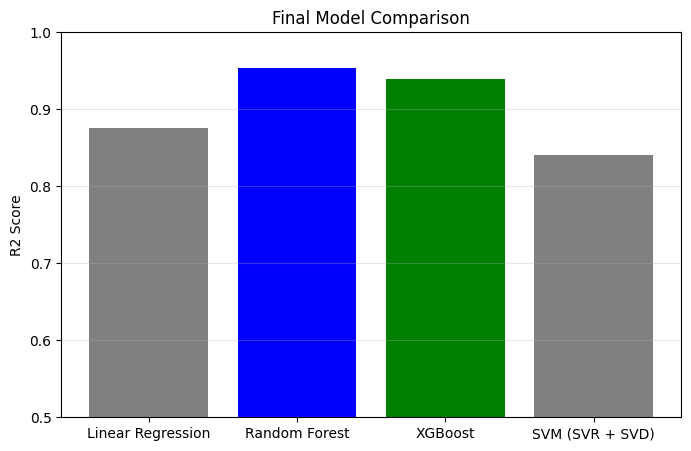

Conclusion: Random Forest is the winner with the best trade-off between accuracy and generalization.


In [57]:
# Comparaison Finale
models_scores = {
    'Linear Regression': 0.875954,
    'Random Forest': 0.953295,
    'XGBoost': 0.93928,
    'SVM (SVR + SVD)': 0.840573
}

plt.figure(figsize=(8, 5))
plt.bar(models_scores.keys(), models_scores.values(), color=['gray', 'blue', 'green'])
plt.ylim(0.5, 1.0)
plt.ylabel('R2 Score')
plt.title('Final Model Comparison')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Conclusion: Random Forest is the winner with the best trade-off between accuracy and generalization.")